Для дизайна А/Б-теста возьмем сценарий, распианный в предыдущем ДЗ. Вкратце напомним, что там было:

Имеется мобильное приложение небольшой региональной сети книжных магазинов. В качестве точки роста была выявлена неэффективно работающая поисковая строка; вектор роста - внедрение нового алгоритма ранжирования поисковой выдачи. Основные метрики продукта - конверсия поиска в добавление в корзину и средняя частота использования поиска в сессию. При положительном исходе мы ожидаем рост среднего по этим метрикам в большую сторону.

Для упрощения дизайна будем использовать функционал библиотеки ambrosia

In [ ]:
!pip install ambrosia

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns

from ambrosia.designer import Designer
from ambrosia.splitter import Splitter
from ambrosia.tester import Tester

Так как мне не удалось найти подходящие данные для данного эксперимента, то придется использовать искусственные. Для моделирования конверсии будем использовать beta-распределение, а для частоты - гамма-распределение. Дополнительно сгенерируем информацию о наиболее часто используемой клиентом платформе

In [54]:
id = np.arange(1, 10001)
convers = sps.beta.rvs(10, 90, size=10000, random_state=42)
freq = sps.gamma.rvs(5.27, size=10000, random_state=42)
os = np.random.choice(['windows', 'ios', 'android'], size=10000, replace=True, p=[0.1, 0.4, 0.5])

df_start = pd.DataFrame(data={'id': id, 'convers': convers, 'freq': freq, 'os': os})
df_start.head()

,id,convers,freq,os
0,1,0.113334,6.124581,android
1,2,0.092889,4.635791,android
2,3,0.137271,4.434472,android
3,4,0.080239,4.434506,android
4,5,0.125493,9.342414,ios


Сперва рассчитаем необходимые размеры выборок для заданных параметров эксперимента: $\alpha = 0.05, \beta = 0.20, MDE = 5\%$; кроме того, стоит принять во внимание, что мы отслеживаем изменение сразу двух метрик, а значит имеет место множественная проверка гипотез. Следовательно, необходимо воспользоваться поправкой Бонферрони и задать индивидуальные ошибки первого рода на уровне 0.025. Саму же проверку на наличие стат. значимых изменений будем стандартно делать при помощи теста Стьюдента

In [72]:
designer = Designer(dataframe=df_start, metrics=['convers', 'freq'], first_type_errors=0.025)

designer.run('size', method='theory', effects=1.05)

{'convers': Errors ($\alpha$, $\beta$) (0.025; 0.2)
 Effect                                 
 5.0%                                676,
 'freq': Errors ($\alpha$, $\beta$) (0.025; 0.2)
 Effect                                 
 5.0%                               1405}

Видим, что достаточно будет взять по 1410 человек в тест и контроль. Теперь сформируем эти группы, с учетом стратификации по используемым платформам

In [ ]:
splitter = Splitter(dataframe=df_start,
                    strat_columns=['os'],
                    fit_columns=['convers', 'freq'])

splitted_df = splitter.run(groups_size=1410, method='hash', salt='exp_322')

In [74]:
splitted_df

,id,convers,freq,os,group
0,1,0.113334,6.124581,android,A
6,7,0.146086,3.965304,android,A
14,15,0.076635,3.823219,android,A
27,28,0.091377,4.297422,android,A
45,46,0.109557,9.292975,android,A
...,...,...,...,...,...
9885,9886,0.112050,6.455886,windows,B
9916,9917,0.108263,2.070875,windows,B
9977,9978,0.085159,3.543734,windows,B
1989,1990,0.150749,1.873043,ios,A


После разбиения необходимо проверить полученные группы на гомогенность. Сначала убедимся в этом визуально

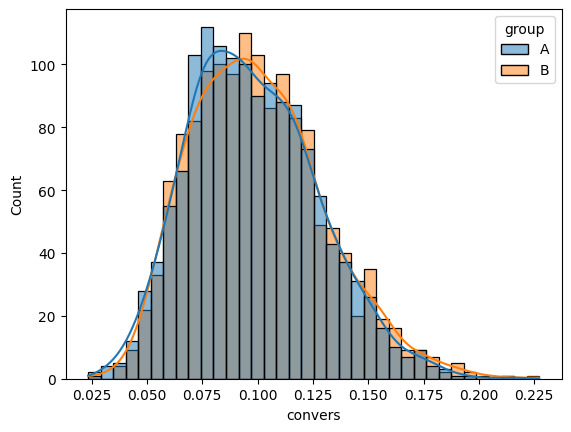

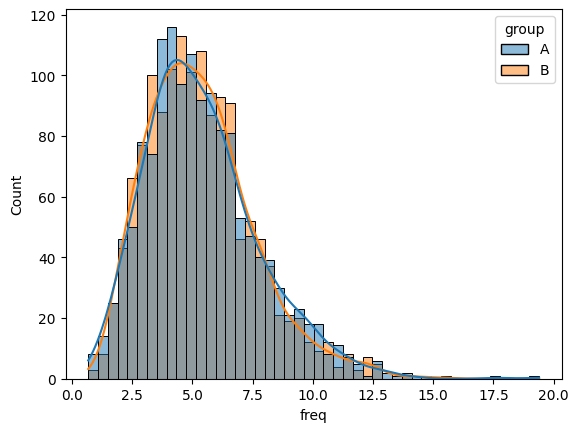

In [75]:
sns.histplot(data=splitted_df, x='convers', hue='group', kde=True)
plt.show()

sns.histplot(data=splitted_df, x='freq', hue='group', kde=True)
plt.show()

Видно, что гистограммы распределений и KDE получились достаточно похожими. Дополнительно можем прогнать A/A-тест и убедится в гомогенности через тест Стьюдента

In [76]:
tester = Tester(dataframe=splitted_df, metrics=['convers', 'freq'], column_groups='group', first_type_errors=0.025)

tester.run(effect_type='relative', method='theory')

,first_type_error,pvalue,effect,confidence_interval,metric name,group A label,group B label
0,0.025,0.157330,0.019971,"(-0.0084, 0.0485)",convers,A,B
1,0.025,0.689355,-0.015168,"(-0.0548, 0.0247)",freq,A,B


По результатам теста видим, что p-value в обоих случаях больше заданной ошибки первого рода, а значит гипотеза о гомогенности метрик не отвергается

Наконец, можем провести полноценный А/Б-тест. Для этого нам опять понадобится сгенерировать данные; при этом в самой генерации изначально заложим значимые различия в метриках

In [78]:
convers_a = sps.beta.rvs(12, 88, size=1410, random_state=42)
freq_a = sps.gamma.rvs(5.8, size=1410, random_state=42)
convers_b = sps.beta.rvs(14, 86, size=1410, random_state=42)
freq_b = sps.gamma.rvs(6.48, size=1410, random_state=42)

df_end = splitted_df.copy(deep=True)
df_end.loc[df_end.group == 'A', 'convers'] = convers_a
df_end.loc[df_end.group == 'B', 'convers'] = convers_b
df_end.loc[df_end.group == 'A', 'freq'] = freq_a
df_end.loc[df_end.group == 'B', 'freq'] = freq_b

df_end.head()

,id,convers,freq,os,group
0,1,0.134704,6.712212,android,A
6,7,0.112941,5.149723,android,A
14,15,0.158735,4.937267,android,A
27,28,0.098421,4.937303,android,A
45,46,0.149930,10.052701,android,A


Сперва вновь проведем визуальную оценку распределений метрик по группам

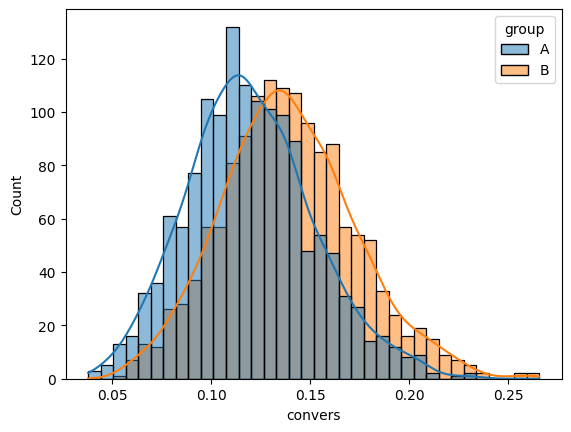

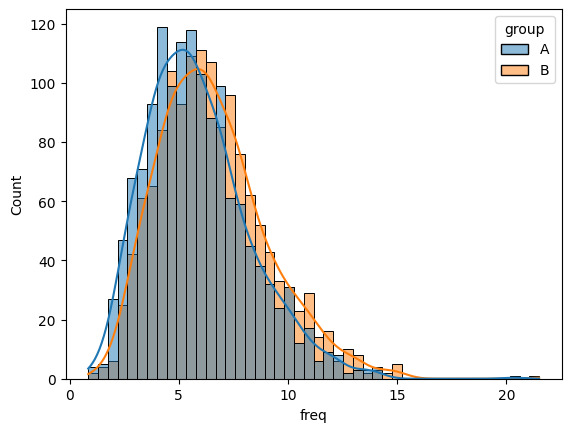

In [79]:
sns.histplot(data=df_end, x='convers', hue='group', kde=True)
plt.show()

sns.histplot(data=df_end, x='freq', hue='group', kde=True)
plt.show()

На графиках уже заметно смещение в положительном направлении распределения метрик в тестовой группе; следовательно, можно ожидать наличие стат. значимого изменения в средних показателях. Чтобы убедиться в этом, воспользуемся тестом Стьюдента

In [81]:
tester = Tester(dataframe=df_end, metrics=['convers', 'freq'], column_groups='group', first_type_errors=0.025)

tester.run(effect_type='relative', method='theory')

,first_type_error,pvalue,effect,confidence_interval,metric name,group A label,group B label
0,0.025,3.593741e-47,0.160859,"(0.1331, 0.1887)",convers,A,B
1,0.025,2.804368e-12,0.116893,"(0.0758, 0.1583)",freq,A,B


Тест Стьюдента также выявил наличие значимых отличий в средних показателях метрик в контрольной и тестовой группах; кроме того, мы можем утверждать, что новый алгоритм ранжирования позволил увеличить показатель конверсии на 16% и показатель частоты использования на 11.7%, что сильно больше зафиксированного MDE. Следовательно, эксперимент можно назвать удачным и выкатить новый алгоритм на всех пользователей приложения.